# Difference between ML and DL on image classification 

---



In [8]:
import numpy as np
import cv2
from scipy.io import loadmat
from sklearn.model_selection import KFold, train_test_split
import keras
from keras import optimizers
from keras.layers import *
from keras.models import Sequential
from skimage.util import montage
import matplotlib.pylab as plt


c:\Users\pc\anaconda3\envs\ENV_MLLB\lib\site-packages\tensorflow\python\framework\dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Load dataset. First, upload the .mat files to Google Colab (in the left menu, click on *Files*/*Upload* to upload the files)

In [2]:
x_all = loadmat('patches_EMPH_4c.mat')['patches']
y_all = loadmat('labels_EMPH_4c.mat')['labels'][0]

Plot the images

(-0.5, 991.5, 991.5, -0.5)

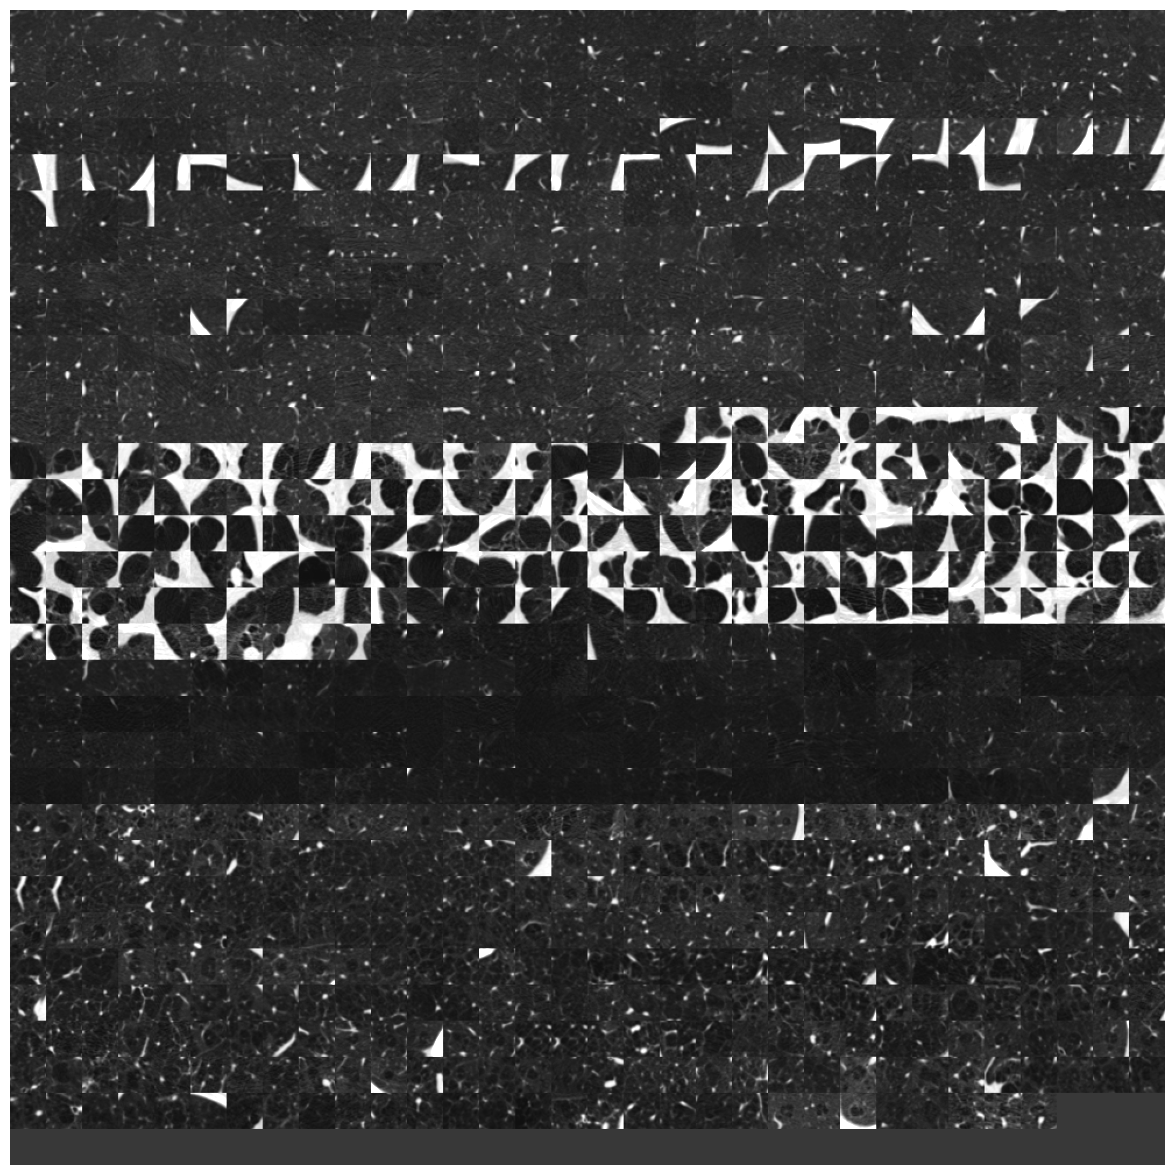

In [3]:
m = montage(x_all)
plt.figure(figsize=(15,15))
plt.imshow(m, 'gray', vmin=-1100, vmax=50)
plt.axis('off')

Images are regions of interest (ROI) extracted from CT images (pixel values in Hounsfield Units, HU).
Normalize the images in the range (0-255)
* HINT/ [cv2 - normalize](https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize). Use **dst**=None, **norm_type**=cv2.NORM_MINMAX and **dtype** = 0

In [4]:
x_norm = cv2.normalize(x_all, dst = None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = 0)


(-0.5, 991.5, 991.5, -0.5)

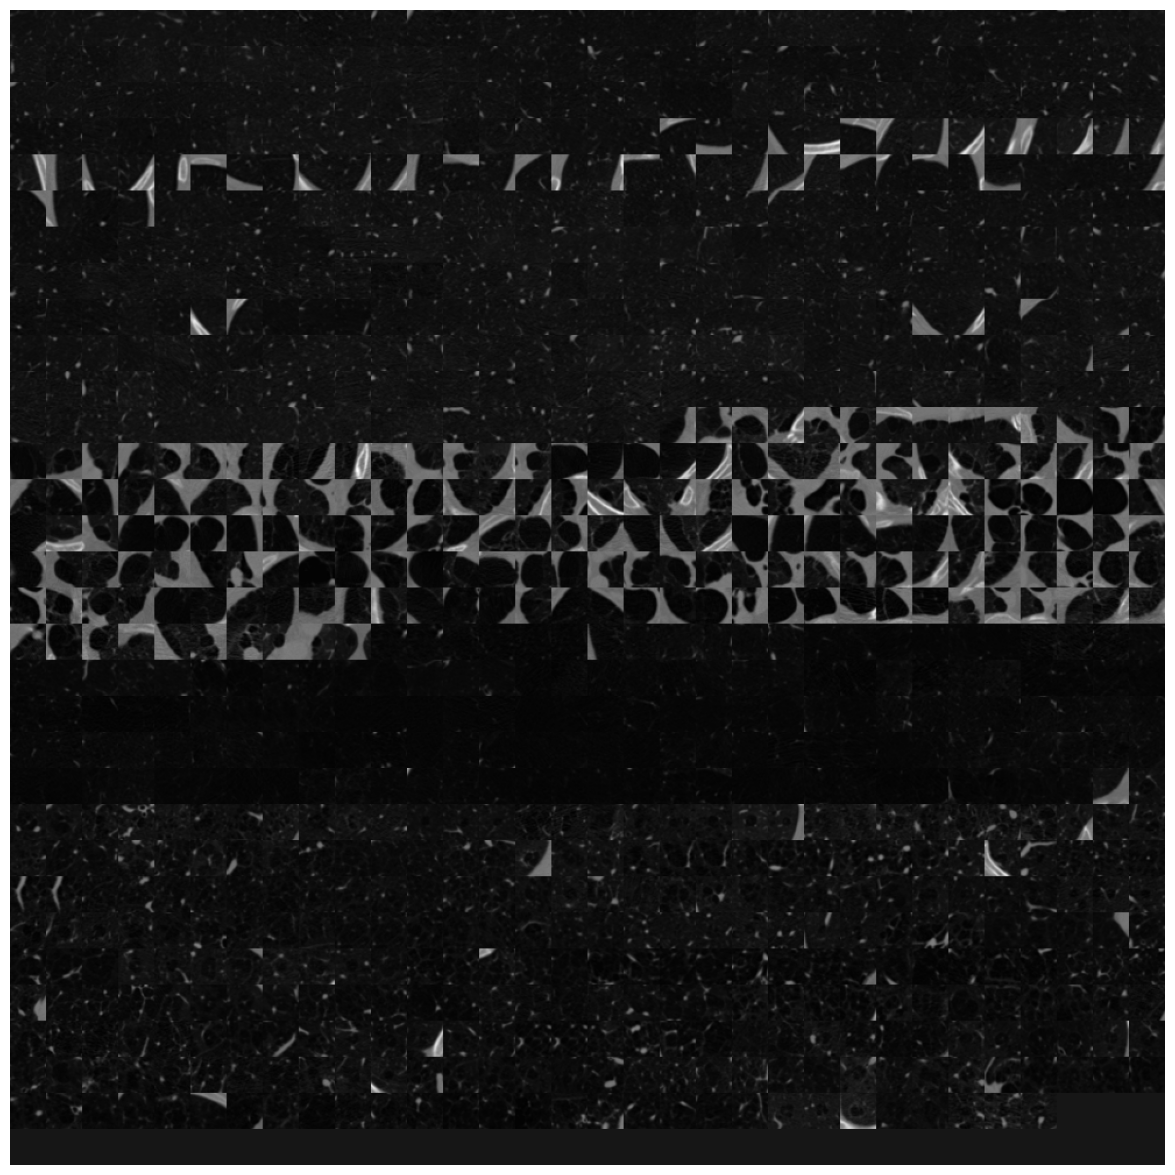

In [5]:
m = montage(x_norm)
plt.figure(figsize=(15,15))
plt.imshow(m, 'gray', vmin=0, vmax=255)
plt.axis('off')

Split dataset into training and testing sets
* HINT/ [sklearn - Train/Test slipt](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* Use **random_state=42** (for reproducibility purposes)
* Use **shuffle=True**

In [6]:
X_train_val = train_test_split(x_norm, y_all, test_size = 0.20, random_state = 42, shuffle = True)[0]
y_train_val = train_test_split(x_norm, y_all, test_size = 0.20, random_state = 42, shuffle = True)[2]
X_test = train_test_split(x_norm, y_all, test_size = 0.20, random_state = 42, shuffle = True)[1]
y_test = train_test_split(x_norm, y_all, test_size = 0.20, random_state = 42, shuffle = True)[3]

In [7]:
print("X_train_val shape:", X_train_val.shape, "Data type:", X_train_val.dtype)
print("y_train_val shape:", y_train_val.shape, "Data type:", y_train_val.dtype)
print("x_test shape:", X_test.shape, "Data type:", X_test.dtype)
print("y_test shape:", y_test.shape, "Data type:", y_test.dtype)

X_train_val shape: (791, 31, 31) Data type: uint8
y_train_val shape: (791,) Data type: int64
x_test shape: (198, 31, 31) Data type: uint8
y_test shape: (198,) Data type: int64


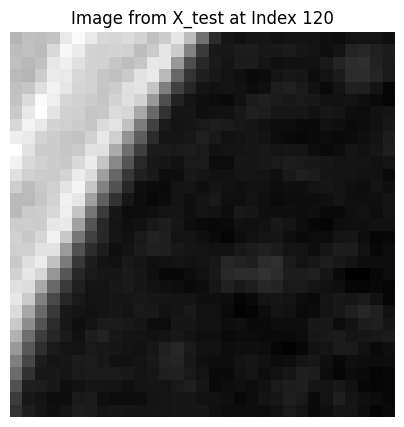

In [8]:
# Select an image from X_test
image_index = 120
image_to_plot = X_test[image_index]

# Display the image
plt.figure(figsize=(5,5))
plt.imshow(image_to_plot.astype(np.uint64), cmap='gray')
plt.title(f"Image from X_test at Index {image_index}")
plt.axis('off')
plt.show()

## Hand-crafted features - Machine Learning

Extract hand-crafted features. You will have to extract a set of features for each image (patch) in the dataset. Remeber to justify the selected features depending on the nature of the problem to solve
* HINT/ Use a for loop for extract features for each image (patch)
* HINT/ Features can be extracted independently, and subsequently contatenated:
```
f1_train_val = shape: (N_train_val_images, num_feat_1)
f2_train_val = shape: (N_train_val_images, num_feat_2)
feat_train = np.concatenate((f1_train_val,f2_train_val), axis=1) #shape: (N_train_val_images, num_feat_1 + num_feat_2)
```
* For feature extraction, you can use any numerical operation on arrays (images) you consider. Additionally, you can use [feature module](https://scikit-image.org/docs/dev/api/skimage.feature.html) from skimage package

### Check the class distributions

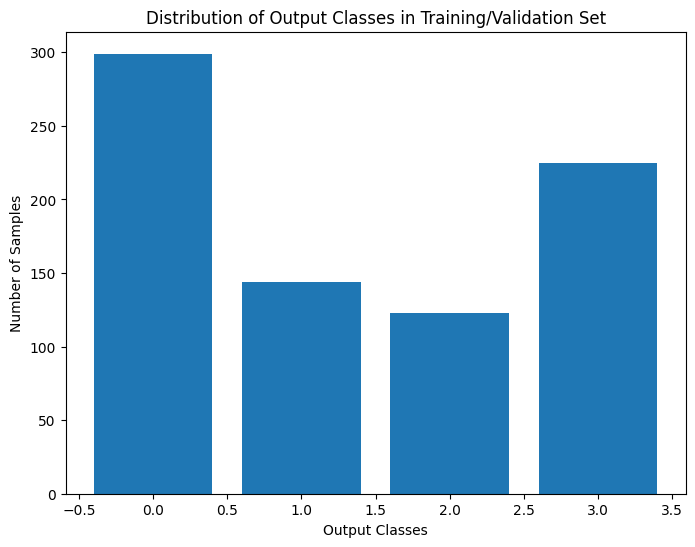

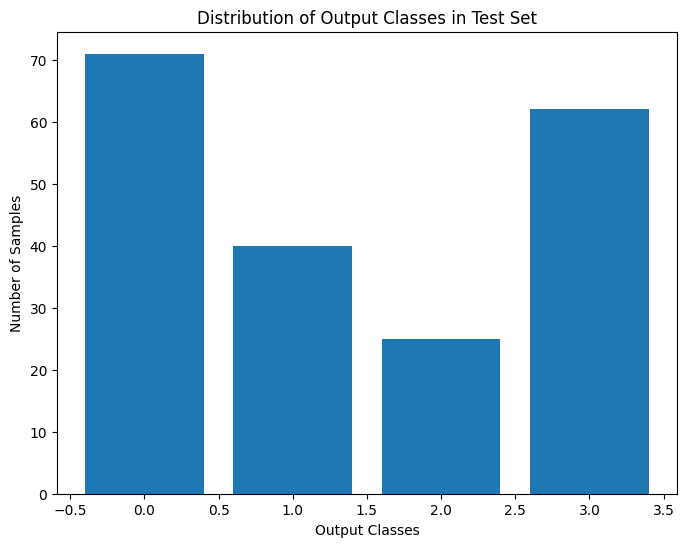

In [9]:
import matplotlib.pyplot as plt

unique_classes, class_counts = np.unique(y_train_val, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts)
plt.xlabel("Output Classes")
plt.ylabel("Number of Samples")
plt.title("Distribution of Output Classes in Training/Validation Set")
plt.show()

unique_classes_test, class_counts_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_classes_test, class_counts_test)
plt.xlabel("Output Classes")
plt.ylabel("Number of Samples")
plt.title("Distribution of Output Classes in Test Set")
plt.show()

The distribution of the different output classes is plotted, to check whether the dataset is balanced or not. As seen on the graphs, the amount of data in the third class is significantly lower compared to the other output classes. An idea could be to downsample the other classes to have an equal distribution in all classes. However, for the sake of this assignment, no data balancing will be performed.

### Extract the features


In [10]:
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog, blob_log, canny
from scipy.stats import skew, kurtosis

def extract_features(images):
  features = []
  for image in images:
    # numerical operations
    mean = np.mean(image)
    std = np.std(image)

    # features from scikit module
    ## local binary pattern
    radius = 3
    n_points = 8*radius
    lbp = local_binary_pattern(image, P = n_points, R = radius, method = 'ror')

    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)

    ## Gray level co-occurence matrix: contrast, dissimilarity, homogeneity, energy and correlation
    glcm = graycomatrix(image.astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    ## Histogram of oriented gradients
    feature_hog = hog(image, visualize=False, feature_vector = True, channel_axis=None)

    ## Multiscale blob detection
    blobs = blob_log(image)
    num_blobs = len(blobs)

    features.append(np.concatenate(([mean, std], lbp_hist, [contrast, dissimilarity, homogeneity, energy, correlation], feature_hog, [num_blobs])))

  return np.array(features)


In [11]:
feat_train_val = extract_features(X_train_val) # SHAPE: (N_train_val_images, N_features)
feat_test = extract_features(X_test) # SHAPE: (N_test_images, N_features)


In [12]:
print(feat_train_val.shape)

(791, 115)


In [13]:
print(feat_train_val)

[[1.66628512e+01 1.23113766e+01 4.18478261e-01 ... 5.07249955e-02
  6.72644920e-02 0.00000000e+00]
 [1.73652445e+01 1.14878934e+01 4.00966183e-01 ... 2.12370918e-02
  1.36335091e-02 0.00000000e+00]
 [1.78709677e+01 9.79477233e+00 4.38775510e-01 ... 5.88143566e-02
  7.50771406e-02 0.00000000e+00]
 ...
 [1.34089490e+01 1.60411244e+01 3.75000000e-01 ... 1.11511904e-01
  4.40545718e-02 0.00000000e+00]
 [5.10353798e+01 4.19429621e+01 3.80116959e-01 ... 3.07873029e-02
  2.41965383e-02 0.00000000e+00]
 [2.25150884e+01 9.35573028e+00 5.02617801e-01 ... 6.00924196e-02
  8.02027374e-02 0.00000000e+00]]


In [14]:
# Check if the values of the feature vectors are normalized
print("Min value in feat_train_val:", np.min(feat_train_val))
print("Max value in feat_train_val:", np.max(feat_train_val))
print("Min value in feat_test:", np.min(feat_test))
print("Max value in feat_test:", np.max(feat_test))

Min value in feat_train_val: 0.0
Max value in feat_train_val: 534.9053763440861
Min value in feat_test: 0.0
Max value in feat_test: 313.1559139784946


### Normalize the feature vectors

In [15]:
from sklearn.preprocessing import RobustScaler

# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler on the training features and transform them
feat_train_val = scaler.fit_transform(feat_train_val)

# Transform the test features using the same scaler
feat_test = scaler.transform(feat_test)

# Verify the normalization
print("Min value in feat_train_val_normalized:", np.min(feat_train_val))
print("Max value in feat_train_val_normalized:", np.max(feat_train_val))
print("Min value in feat_test_normalized:", np.min(feat_test))
print("Max value in feat_test_normalized:", np.max(feat_test))

Min value in feat_train_val_normalized: -2.883207135092185
Max value in feat_train_val_normalized: 10.558142133908516
Min value in feat_test_normalized: -2.2175568787364552
Max value in feat_test_normalized: 6.61460795198045


---
**SUITABILITY AND JUSTIFICATION OF THE EXTRACTED FEATURES BASED ON THE CLASSIFICATION PROBLEM TO SOLVE**


Following features are extracted from the images:
- Mean: this basic feature captures the average brightness of the tissue in the image.
- Standard deviation: this basic feature captures the variation in pixel intensities within the image.
- Local binary pattern: this feature is often used in texture classification and is grayscale and rotation invariant. Capturing texture information is essential to distinguish between lung tissue patterns.
- Gray level co-occurence matrix (GLCM): this matrix is a histogram of co-occurring grayscale values at a given offset over an image. GLCM-based features are related to texture properties of the image such as contrast, dissimilarity, homogeneity, energy and correlation. As lung tissue patterns can have different texture properties, these featuers are very useful.
- Histogram of oriented gradients: this feature is useful for gradient-based features. A gradient is present on an image when there are structural changes in the lung tissue patterns.
- Multiscale blob detection using the laplacian of gaussian method. As emphysema often show blob-like structures, the number of blobs are counted and created as an extra informative feature.


---

Create several classifiers. At least you need to create the following ones:
1.   K-NN (HINT/ [sklearn - KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier))
2.   SVM. You can try different kernels. (HINT/ [sklearn - SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html))
3.   MLP (HINT/ [sklearn - MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier))


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier


Train and compare the classifiers. Use a **5**-Fold Cross-Valiation strategy to choose the best classifier based on the accuracy
*   HINT/ [sklearn - KFold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
*   HINT/ [sklearn - Accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [17]:
def model_training(cl):
  ACC = []
  kf = KFold(n_splits=5, shuffle=True, random_state=None)
  for cv_train_index, cv_val_index in kf.split(feat_train_val):
      feat_cv_train, feat_cv_val = feat_train_val[cv_train_index], feat_train_val[cv_val_index]
      y_cv_train, y_cv_val = y_train_val[cv_train_index], y_train_val[cv_val_index]
      #Train
      cl.fit(feat_cv_train, y_cv_train)
      #Predict
      yhat = cl.predict(feat_cv_val)
      #Compute CV metrics
      acc = accuracy_score(y_cv_val, yhat, normalize=True, sample_weight=None)
      ACC.append(acc)
  return np.mean(ACC)

In [18]:
cl1 = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
cl2 = SVC(kernel='linear', C=1, probability=True)
cl3 = SVC(kernel='poly', degree = 3, probability=True)
cl4 = xgb.XGBClassifier(objective="multi:softprob", random_state=42, reg_alpha = 0.1, reg_lambda = 1)
cl5 = LogisticRegression(solver = 'liblinear', max_iter = 500, random_state=42)
cl6 = DecisionTreeClassifier(random_state=42)
cl7 = RandomForestClassifier(random_state=42)
cl8 = MLPClassifier(solver='adam', activation = 'relu', alpha=1e-5, hidden_layer_sizes=(100,), random_state=42, max_iter = 500, early_stopping = False)

classifiers = [cl1, cl2, cl3, cl4, cl5, cl6, cl7, cl8]
classifier_names = ['KNN', 'SVM with linear kernel', 'SVM with polynomial kernel', 'XGBoost', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'MLP']

for i, clf in enumerate(classifiers):
  mean_accuracy = model_training(clf)
  print(f'{classifier_names[i]}: {mean_accuracy}')

voting_clf_soft = VotingClassifier(estimators=[(name, clf) for name, clf in zip(classifier_names, classifiers)], voting='soft')

# Train the VotingClassifier
mean_accuracy_voting_soft = model_training(voting_clf_soft)
print(f'Soft Voting Classifier: {mean_accuracy_voting_soft}')

KNN: 0.6144256030570814
SVM with linear kernel: 0.7686808375129368
SVM with polynomial kernel: 0.6270679086060027
XGBoost: 0.8950720484037895
Logistic Regression: 0.790120213358809
Decision Tree: 0.8065838707109307
Random Forest: 0.8343523604808535
MLP: 0.7964334049836796
Soft Voting Classifier: 0.8684499641748269


## Overview of models with evaluation metrics on train and validation set

In [19]:
def model_evaluation(cl, model_name, plot = False):
  ACC_train = []
  ACC_val = []
  kf = KFold(n_splits=5, shuffle=True, random_state=None)
  for cv_train_index, cv_val_index in kf.split(feat_train_val):
      feat_cv_train, feat_cv_val = feat_train_val[cv_train_index], feat_train_val[cv_val_index]
      y_cv_train, y_cv_val = y_train_val[cv_train_index], y_train_val[cv_val_index]
      #Train
      cl.fit(feat_cv_train, y_cv_train)
      #Predict
      yhat_val = cl.predict(feat_cv_val)
      yhat_train = cl.predict(feat_cv_train)
      #Compute CV metrics
      acc_val = accuracy_score(y_cv_val, yhat_val, normalize=True, sample_weight=None)
      ACC_val.append(acc_val)
      acc_train = accuracy_score(y_cv_train, yhat_train, normalize=True, sample_weight=None)
      ACC_train.append(acc_train)

  # yhat_test_ML = cl.predict(feat_test)
  # test_acc_ML = accuracy_score(y_test, yhat_test_ML, normalize=True, sample_weight=None)

  print(f'--------Evaluation metric for {model_name}------------')
  print('Accuracy for training set: ', np.mean(ACC_train))
  print('Accuracy for validation set: ', np.mean(ACC_val))
  # print('Accuracy for test set: ', test_acc_ML)

  if plot == True:
    # Bar plot for accuracy comparison
    accuracy_scores = [np.mean(ACC_train), np.mean(ACC_val), test_acc_ML]
    labels = ['Train', 'Validation', 'Test']

    plt.figure(figsize=(8, 6))
    plt.bar(labels, accuracy_scores, color=['blue', 'orange', 'green'])
    plt.title(f'Accuracy Comparison for {model_name}')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])  # Set y-axis limits to 0-1 for accuracy
    plt.show()

  return None

In [20]:
for i, clf in enumerate(classifiers):
  model_evaluation(clf, classifier_names[i])

--------Evaluation metric for KNN------------
Accuracy for training set:  0.7537954686343912
Accuracy for validation set:  0.6233818963458322
--------Evaluation metric for SVM with linear kernel------------
Accuracy for training set:  0.9898854160417543
Accuracy for validation set:  0.7914974922378791
--------Evaluation metric for SVM with polynomial kernel------------
Accuracy for training set:  0.9096066550682904
Accuracy for validation set:  0.6259055807658626
--------Evaluation metric for XGBoost------------
Accuracy for training set:  1.0
Accuracy for validation set:  0.891298463498129
--------Evaluation metric for Logistic Regression------------
Accuracy for training set:  0.9405823184754134
Accuracy for validation set:  0.790096329910039
--------Evaluation metric for Decision Tree------------
Accuracy for training set:  1.0
Accuracy for validation set:  0.788830507125229
--------Evaluation metric for Random Forest------------
Accuracy for training set:  1.0
Accuracy for validati

In [21]:
model_evaluation(voting_clf_soft, "Soft Voting Classifier")

--------Evaluation metric for Soft Voting Classifier------------
Accuracy for training set:  1.0
Accuracy for validation set:  0.8609585224106361


Compute the mean accuracy of each classifier, and select the best one

---
**COMPARATIVE STUDY BETWEEN DIFFERENT ML CLASSIFIERS**

- As the learning process of these different ML classifiers is dependent on chance, the performance metrics (i.e. the mean accuracies) vary slightly when retraining the models. Therefore, the conclusions made below try to take this variability into account.
- When retraining the models a couple of times, the models that achieve the highest mean accuracy for the validation set are XGBoost and the Soft voting classifier.
- The lowest mean accuracy is achieved for the K-Nearest Neighbors and the SVM with polynomial kernel.


### K-Nearest Neighbors (KNN): cl1
This classifier works by finding the k-nearest data points to a new data point and classifying it based on the majority class among those neighbors. It is easy to understand and implement, but can be computationally expensive for large datasets. KNN performs quite bad on the validation set, as the algorithm's simplicity and reliance on local neighbors might not capture complex patterns in the dataset.

Parameters:
- n_neighbors parameter is 5
- Euclidean distance metric (p=2, metric='minkowski').

### Support Vector Machine (SVM) - Linear Kernel: cl2
This classifier aims to find the optimal hyperplane that best separates data points of different classes.

Parameters:
- kernel='linear' indicates that a linear kernel is used, which assumes that the classes are linearly separable
- C=1 is the regularization parameter, controlling the trade-off between maximizing the margin and minimizing classification error

### Support Vector Machine (SVM) - Polynomial Kernel: cl3
This classifier is similar to the linear SVM but uses a polynomial kernel to map data points to a higher-dimensional space, allowing for non-linear decision boundaries.

Parameters:
- kernel='poly' indicates the use of a polynomial kernel
- degree=3 specifying the degree of the polynomial. This can lead to more complex decision boundaries and might increase the risk of overfitting, visible on the drop in performance between the training and validation set.  

#### Comparison SVM with Linear and Polynomial Kernel
The Support Vector Machine Classifier with a linear kernel scores moderately well. However, when using the SVM Classifier with a polynomial kernel the accuracy reaches one of the lowest values of all classifiers. We suggest that the polynomial kernel results in a complex decision boundary which is suboptimal to classify the data. This results in low accuracy values for the training and validation set. Based on the high accuracy score of the SVM with linear kernel, we can conclude that the classes are approximately linearly separable.

### XGBoost: cl4
XGBoost is a gradient boosting algorithm that combines multiple weak learners (decision trees) to create a strong learner. XGBoost relies on an additive process of multiple decision trees. In each iteration, a new optimized decision tree is build by minimizing the error of the previous decision tree. The XGBClassifier applies both a L1 and L2 regularization which tries to minimize the risk of overfitting. XGBoost demonstrates excellent performance on the validation set, indicating robustness and the ability to handle both linear and non-linear relationships. This results in excellent accuracy values on the validation dataset. However, the perfect training accuracy (= 1) suggests some risk of overfitting.

Parameters:
- objective="multi:softprob" is used for multi-class classification with probability outputs
- random_state=42 ensures reproducibility
- reg_alpha=0.1 and reg_lambda=1 are regularization parameters to prevent overfitting.

### Logistic Regression: cl5
This classifier is used for binary or multi-class classification problems and models the probability of a data point belonging to a particular class. Logistic Regression results in simple and easy to interprete models. In this case, Logistic Regression results in good accuracy values for the training and validation. As this model is assuming linear separable classes, we can conclude that the classes are approximately linearly separable.

Parameters:
- solver='liblinear' is chosen for the optimization algorithm, which is suitable for smaller datasets
- max_iter=500 sets the maximum number of iterations for the solver to converge

### Decision Tree: cl6
This classifier creates a tree-like structure to make decisions based on a series of rules inferred from the features. Decision trees are prone to overfitting if not carefully pruned. The perfect training accuracy highlights overfitting, as the model captures noise in the training data. This is confirmed on the performance on the validation set, which is significantly lower.

Parameters:
- random_state=42 ensures reproducibility in the tree construction.

### Random Forest: cl7
This classifier combines multiple decision trees to improve generalization and to reduce overfitting. It is generally more robust than a single decision tree. Random Forest mitigates overfitting better than a standalone Decision Tree, but the high training accuracy still suggests potential overfitting.

Parameters:
- random_state=42 ensures reproducibility in the forest construction

### Multi-layer Perceptron (MLP): cl8
This classifier is a type of neural network with multiple layers of interconnected nodes. The accuracy is reasonably high, reflecting the MLP's ability to learn complex patterns while maintaining generalization. The drop in validation accuracy compared to training indicates also here a risk of overfitting.

Parameters:
- solver='adam' is used for optimization
- activation='relu' specifies the activation function for hidden layers
- alpha=1e-5 is the regularization parameter
- hidden_layer_sizes=(100,) defines the architecture with one hidden layer of 100 neurons

### Voting Classifier
A voting classifier is an ensemble method that aims to improve predictive performance by combining outputs of multiple classifiers. Soft majority voting makes the final prediction based on the probability scores for each class predicted by the individual models. By aggregating the prediction of different models, it is possible that a combination of classifiers outperforms most of the individual classifiers.

---

Once the best classifier has already been identified (based on the mean accuracy over the folds) and trained, compute the Accuracy and the Confusison Matrix on the independent test set. You can use the model trained in the last fold
* HINT/ [sklearn - Confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [22]:
from sklearn.metrics import confusion_matrix
# Best model: XGBoost
# This result is determined after retraining the models multiple times

yhat_test_ML = cl4.predict(feat_test)
test_acc_ML = accuracy_score(y_test, yhat_test_ML, normalize=True, sample_weight=None)
test_confusion_matrix_ML = confusion_matrix(y_test, yhat_test_ML, labels=None, sample_weight=None, normalize=None)

In [23]:
print('Test ACC of the best ML model:', test_acc_ML)
print('\n')
print('CM of the best ML model:\n', test_confusion_matrix_ML)

Test ACC of the best ML model: 0.9090909090909091


CM of the best ML model:
 [[68  1  0  2]
 [ 2 38  0  0]
 [ 0  0 23  2]
 [ 4  2  5 51]]


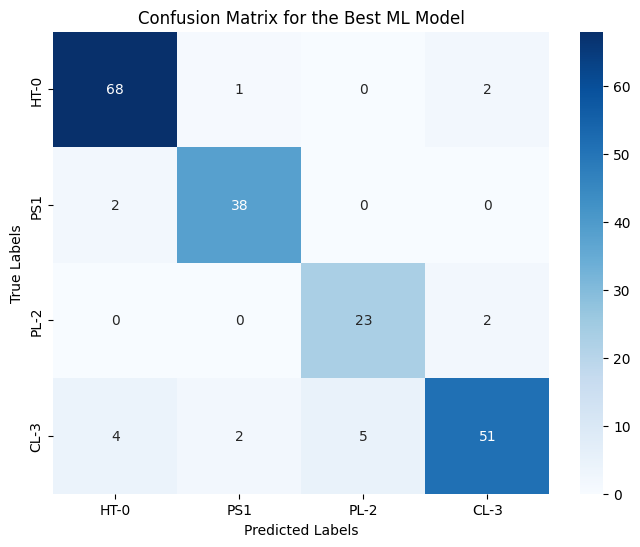

In [24]:
import seaborn as sns

labels = ['HT-0', 'PS1', 'PL-2', 'CL-3']

plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix_ML, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for the Best ML Model")
plt.show()


## Learned features - Deep Learning

Define a method which creates and returns the CNN model
* HINT/ See example guides to construct DL models using Keras [here](https://keras.io/getting-started/sequential-model-guide/) and [here](https://keras.io/examples/cifar10_cnn/)
* [Conv layers](https://keras.io/layers/convolutional/)
* [Norm layers](https://keras.io/layers/normalization/)
* [Pooling layers](https://keras.io/layers/pooling/)
* [Dense layers](https://keras.io/layers/core/)


In [25]:
from keras.layers import *
from keras.models import Sequential
from keras.optimizers import SGD
import numpy as np

In [26]:
def cnn(num_classes):
    model = Sequential()

    # Block 1
    model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(31,31,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Block 3
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(Dropout(0.5))
    model.add(Dense(64, activation='linear'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    opt = SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Convert the ground truth (labels) to categorical.
For example, if there are 4 classes:
* y = 0 --> 0000
* y = 1 --> 0010
* y = 2 --> 0100
* y = 3 --> 1000


In [27]:
import tensorflow as tf
num_classes = 4
y_train_val_keras = keras.utils.to_categorical(y_train_val, num_classes=num_classes)
y_train_val_keras = y_train_val_keras.astype('float32')

# num_classes = 4
# y_train_val_keras = keras.utils.to_categorical(y_train_val, num_classes=num_classes, dtype = "float32")

In [28]:
print(y_train_val[0],'-->',y_train_val_keras[0])
print(y_train_val[5],'-->',y_train_val_keras[5])

3 --> [0. 0. 0. 1.]
0 --> [1. 0. 0. 0.]


For 2D images, we need the X_train array with 4 dimensions: (Number_of_samples, W, H, number_of channels). As the images are in grey-scale, X_train needs to be (N,W,H,1)



In [29]:
print(X_train_val.shape, X_test.shape)

(791, 31, 31) (198, 31, 31)


In [30]:
X_train_val = np.expand_dims(X_train_val, 3)
X_test = np.expand_dims(X_test, 3)

In [31]:
print(X_train_val.shape, X_test.shape)

(791, 31, 31, 1) (198, 31, 31, 1)


Train (fit) the CNN
* HINT/ [keras - fit](https://keras.io/models/model/#fit)
* Use a callback to incorporate Early Stoppinng in the training procedure. See [Usage of callbacks](https://keras.io/callbacks/) and [Early Stopping](https://keras.io/callbacks/#earlystopping)

In [32]:
num_classes = 4
cnn_model = cnn(num_classes)
print(cnn_model.summary())
callbacks = [
    keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
]
history = cnn_model.fit(X_train_val, y_train_val_keras, batch_size = 100, validation_split = 0.2, epochs = 100, callbacks = callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 29, 29, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 29, 29, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2, 2, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,932 (113.02 KB)

 Trainable params: 28,708 (112.14 KB)

 Non-trainable params: 224 (896.00 B)

None
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 864ms/step - accuracy: 0.3937 - loss: 2.2320 - val_accuracy: 0.2138 - val_loss: 3.5837
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6823 - loss: 1.1135 - val_accuracy: 0.2201 - val_loss: 3.0126
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7209 - loss: 0.7833 - val_accuracy: 0.2264 - val_loss: 2.8343
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7994 - loss: 0.5994 - val_accuracy: 0.2201 - val_loss: 2.6165
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7944 - loss: 0.5991 - val_accuracy: 0.2201 - val_loss: 2.3797
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8642 - loss: 0.4233 - val_accuracy: 0.2201 - val_loss: 2.2476
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8577 - loss: 0.4286 - val_accuracy: 0.2201 - val_loss: 2.4243
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8502 - loss: 0.4236 - val_accuracy: 0.2390 - val_

Plot training and validation values

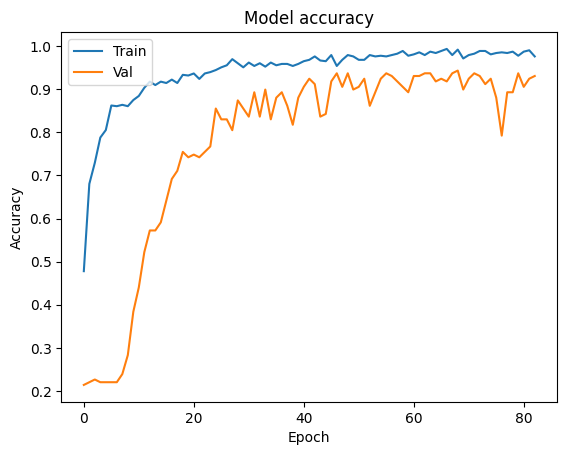

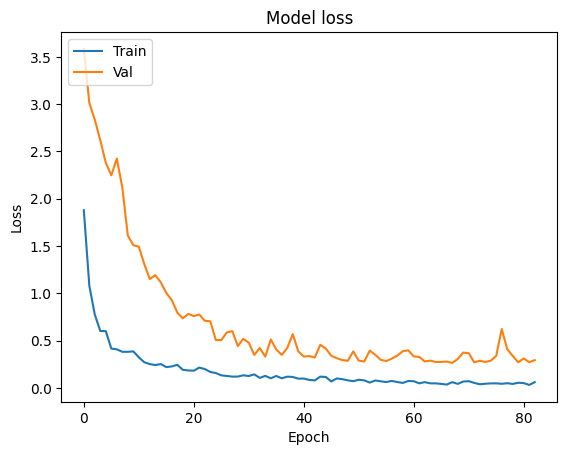

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

---
**EXPLANATION OF THE CONVOLUTIONAL NETWORK USED AND ITS TRAINING PROCESS**

### Preprocessing
- The ground truth labels are hot-encoded by using a conversion to categorical variables in which as many zeros are present as output classes and a single one is placed to refer to a certain class.  One-hot encoding has the advantage to avoid the misinterpretation of categorical data as having some ordinal significance.

### Convolutional neural network architecture
- The convolution neural network consists of three blocks containing each time a 2D-convolutional layer, batch normalization and max pooling layer.
--  The conv layer is responsible for extracting certain features from the input images. This is done by convoluting a kernel of size 3x3 with the input image (or further in the network with the feature maps). The resulting size of the feature map is dependent on the applied stride (= 2), padding (= 0), input dimension and kernel size (= 3).  
-- The batch normalization layer is responsible for a normalization after a whole batch went through the network.
-- The max pooling layer is responsible for downsizing the feature maps in order to only have attention to the most relevant features and to have a dimensionality reduction.

- An input shape of (31,31,1) is chosen, as the height and width of the input images are (31, 31). The third dimension, i.e. the number of channels, is equal to 1 as the input images are grayscale images with a value between 0 (= black) and 255 (= white).  
- A dropout layer is also included in the CNN architecture with a dropout probability of 0.5. This means that during the training process, 50% of the nodes in specific layers of the network are randomly dropped. To drop nodes means that they are set to 0 and cannot pass any information anymore to the next layers. This procedure avoids that the output for a sample depends on very specific paths through the network. This is a regularization technique that prevents overfitting, meaning that the model would not be able to perform well on unseen data anymore.

- The number of output neurons is equal to 4, as there are four classes to which the input images can belong to, namely healthy tissue (HT-0), paraseptal emphysema (PS1), panlobular emphysema (PL-2) and centrilobular emphysema (CL-3).

- For the first three blocks, a relu activation function is used which deactivate the neuron if negative values are received and keeps the same value if positive values are received. For the final output layer, an softmax activation function is used. This returns for every of the four output neurons an number between 0 and 1, corresponding to the probability of the corresponding class. As the softmax activation is used, the sum of the predicted probabilities that a certain input image belongs to each of the four classes will be equal to 1.

### Training process
- The stochastic gradient descent optimization method is used to iteratively train the model’s weights with a learning rate of 0.01. A higher learning rate can lead to a faster convergence of the model, but can cause the optimization algorithm to overshoot or oscillate around the optimal solution.
- The categorical cross-entropy loss function is used to calculate the difference between the predicted class label and the real class label.
- The accuracy is chosen as validation metric, which represents the ratio of correctly predicted labels to the total number of images in the dataset.
- The number of epochs is equal to 100. After 1 epoch, the whole training data set has been used to optimize the parameters of the model.
- A batch size of 100 is used, which is defined as a subset of the data that is used to update the model weights in each iteration. So multiple batches with each a batch size of 100 images will used in order to train the model. From the moment the entire training data set has been used, one epoch has been performed. Performing batch processing has the advantage to utilize the memory in an efficient way and improve the training speed.

- The network incorporates early stopping in the training procedure. This means that if in this case the validation loss has stopped improving after a number of 15 epochs (= patience), the training will be stopped. Early stopping is a kind of regularization technique that prevents the model of overfitting. If the training will be stopped, those weights are chosen that correspond to the lowest value of the validation loss.

- The complete dataset is split into 20% for testing and 80% for training+validation. This step is crucial to evaluate whether the model can generalize well to new, unseen (i.e. not “seen” during training) data. Then during the cnn_model.fit() function, the training+validation dataset is again split into 20% for validation and 80% for training. This validation set is used perform hyperparameter tuning and assess it in a reliable manner.

### Results
- As visible on the first plot, it is clear that the accuracy of the model predictions for the training dataset goes up, as well as for the validation dataset. If more epochs would be used, the accuracy on the training dataset would in theory keep increasing, whereas on the validation dataset it would start to decrease. This means that the model starts to overfit. This is prevented by the use of Early Stopping or the integration of dropout layers. The same conclusions can be made when looking at the learning curve (model loss vs epochs) at the bottom.


---

Once the CNN has been trained, compute test accuracy and the confusion matrix on the test set
* HINT/ [keras-predict](https://keras.io/models/model/#predict) returns an array with the output probability distribution
* HINT/ Use the [argmax function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) to get the predicted classes, which are those with highest probability

In [34]:
from sklearn.metrics import confusion_matrix

yhat_proba_test_DL = cnn_model.predict(X_test)
print(yhat_proba_test_DL.shape)
yhat_test_DL = np.argmax(yhat_proba_test_DL, axis = 1)
test_acc_DL = accuracy_score(y_test, yhat_test_DL, normalize=True, sample_weight=None)
test_confusion_matrix_DL = confusion_matrix(y_test, yhat_test_DL, labels=None, sample_weight=None, normalize=None)
print('Test ACC of CNN model:', test_acc_DL)
print('\n')
print('CM of CNN model:\n', test_confusion_matrix_DL)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
(198, 4)
Test ACC of CNN model: 0.9595959595959596


CM of CNN model:
 [[69  1  0  1]
 [ 0 37  2  1]
 [ 0  0 25  0]
 [ 0  1  2 59]]


In [35]:
print('predicted output for the fifth image:', yhat_proba_test_DL[4])
print('sum of predicted outputs for the fifth image:', np.sum(yhat_proba_test_DL[4]))
print('predicted label for the fifth image:', np.argmax(yhat_proba_test_DL[4]))
print('actual label for the fifth image:', y_test[4])

predicted output for the fifth image: [9.9948102e-01 1.0346402e-07 4.8124167e-07 5.1841629e-04]
sum of predicted outputs for the fifth image: 1.0
predicted label for the fifth image: 0
actual label for the fifth image: 0


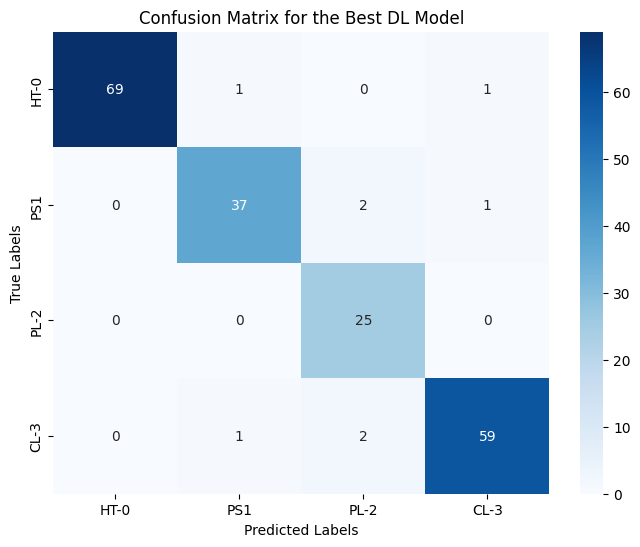

In [36]:
import seaborn as sns

labels = ['HT-0', 'PS1', 'PL-2', 'CL-3']

plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix_DL, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for the Best DL Model")
plt.show()

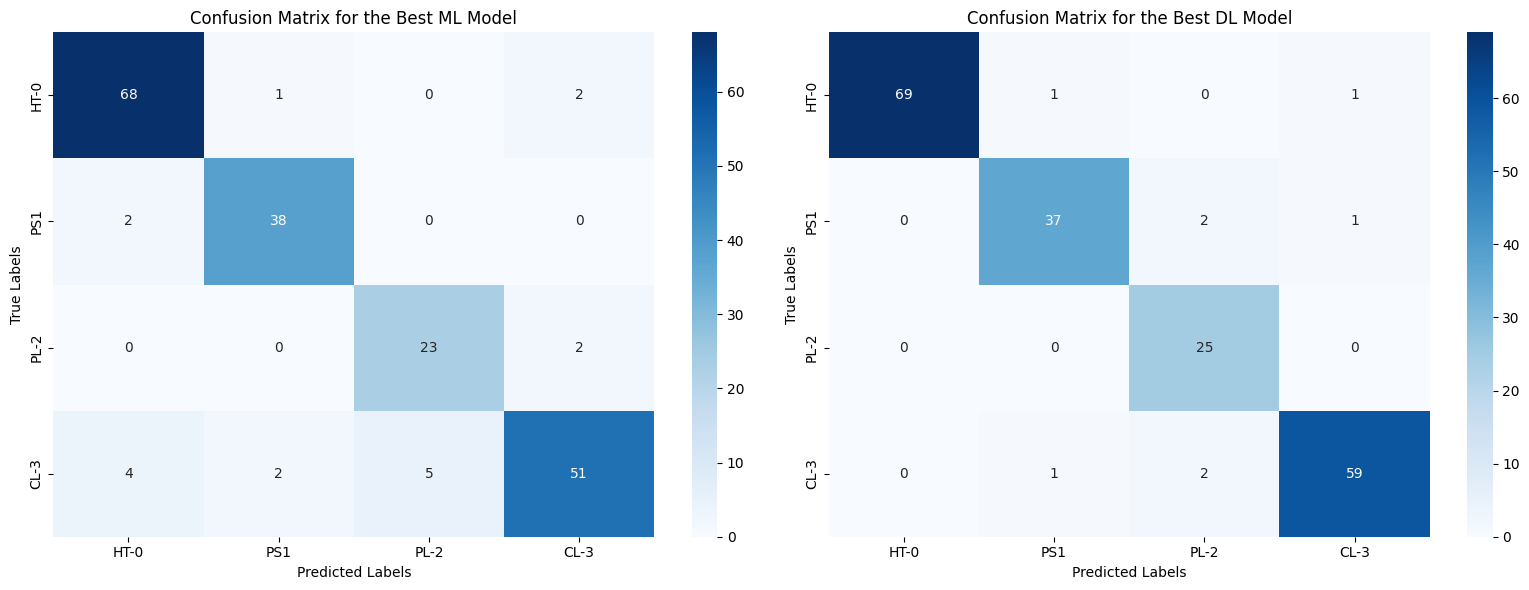

In [37]:
labels = ['HT-0', 'PS1', 'PL-2', 'CL-3']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix for ML Model
sns.heatmap(test_confusion_matrix_ML, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
axes[0].set_title("Confusion Matrix for the Best ML Model")

# Confusion Matrix for DL Model
sns.heatmap(test_confusion_matrix_DL, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
axes[1].set_title("Confusion Matrix for the Best DL Model")

plt.tight_layout()
plt.show()

In [38]:
print('Test ACC of the best ML model:', test_acc_ML)
print('Test ACC of CNN model:', test_acc_DL)

Test ACC of the best ML model: 0.9090909090909091
Test ACC of CNN model: 0.9595959595959596


## Comparative study (ML vs DL)

---
**COMPARATIVE STUDY BETWEEN ML AND DL RESULTS**

Comparing the confusion matrices, generated based on the same test set, for both the best machine learning (XGBoost model) and deep learning (CNN) model, it is clear that the deep learning model is more able to accurately predict the correct class of the input images. This trend is also reflected in the accuracy of both methods: 0.91 for the ML model and 0.96 for the DL model. Therefore, the Convolutional Neural Network outperforms the XGBoost model with an increase in accuracy of 5%. Note that the training processes for the ML and DL model are stochastic processes, so when retraining the models, slightly different results can be obtained. However, when performing the training multiple times, it becomes clear that the CNN will outperform most of the times the XGBoost model.

The reason for this is that the Deep Learning method is and end-to-end pipeline where the feature extraction is automatically done by from the input data. Therefore, it is more able to extract those properties from the images that are determinant for the class to which those images belong to.

---

## Final conclusions

---
**CONCLUCIONS**

The main objective of this practical exercise was to classify lung tissue images into one of four classes: healthy tissue (HT-0), paraseptal emphysema (PS1), panlobular emphysema (PL-2), and centrilobular emphysema (CL-3). Two main techniques were applied and compared for classification, i.e. a machine learning (ML) approach and a deep learning (DL) approach.

For the machine learning approach, hand-crafted features were extracted and used as input for the ML classifiers. A 5-fold cross-validation strategy was applied to train and compare multiple classifiers, i.e. K-nearest neighbors (KNN), support vector machine (SVM), XGBoost, Logistic regression, decision tree, random forest, neural network and a voting classifier. The best-performing classifier corresponded to the XGBoost classifier, which was then evaluated on an independent test set to report the final performance, i.e. an accuracy of around 91%.

For the deep learning approach, a convolutional neural network (CNN) was implemented and trained for end-to-end classification. Similarly, the CNN model's performance was reported on an independent test set and resulted in an accuracy of 96%.

The results showed that both the ML and DL models could classify the lung tissues, but the DL approach outperformed the ML approach achieving an accuracy of 96% vs 91% respectively. This suggests that the automatic feature extraction by the CNN is better than the hand-crafted features engineered for the ML approach.

---